In [1]:
#Imports
import math
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from matplotlib import pyplot

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#Import the data after preprocessing
training = pd.read_csv("training.csv").iloc[:,1:]
validation = pd.read_csv("validation.csv").iloc[:,1:]
test = pd.read_csv("test.csv").iloc[:,1:]

#Split the data into X and y, input and output features
x_train = training.iloc[:,:-1]
y_train = training.iloc[:,-1:]

x_valid = validation.iloc[:,:-1]
y_valid = validation.iloc[:,-1:]

x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

print("Training set: ")
print(x_train.shape)
print(y_train.shape)
print(Counter(y_train.iloc[:,0]),"\n")

print("Validation set: ")
print(x_valid.shape)
print(y_valid.shape)
print(Counter(y_valid.iloc[:,0]),"\n")

print("Test set: ")
print(x_test.shape)
print(y_test.shape)
print(Counter(y_test.iloc[:,0]),"\n")

Training set: 
(173, 25)
(173, 1)
Counter({0: 110, 1: 63}) 

Validation set: 
(43, 25)
(43, 1)
Counter({0: 27, 1: 16}) 

Test set: 
(73, 25)
(73, 1)
Counter({0: 47, 1: 26}) 



In [3]:
#Evaluation Function for classification
def evaluation(x_valid, y_valid, y_pred, model):

    #Confusion Matrix
    conf = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:\n",conf,"\n")
    
    #report
    target_names = ['0', '1']
    print(classification_report(y_valid, y_pred, target_names=target_names))

    #ROC curve and AUC
    plot_roc_curve(model, x_valid, y_valid, color="purple") 
    pyplot.show()

Confusion Matrix:
 [[25  2]
 [ 8  8]] 

              precision    recall  f1-score   support

           0       0.76      0.93      0.83        27
           1       0.80      0.50      0.62        16

    accuracy                           0.77        43
   macro avg       0.78      0.71      0.72        43
weighted avg       0.77      0.77      0.75        43



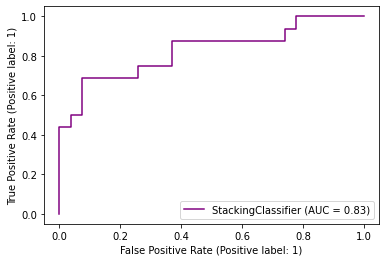

In [4]:
# Creating base model, no hyperparameter tuning
# Level 0 Learners
base_learners = {
    "kNN": KNeighborsClassifier(),
    "logistic": LogisticRegression(),
    "forest": RandomForestClassifier(random_state = 21)
}


#Creating the level0 learners
lvl0 = []
for i in base_learners.keys():
    lvl0.append((i,base_learners[i]))

#Creating meta learner (level1 learner), logistic regression common for classification
lvl1 = LogisticRegression()

#Creating the stack model
model = StackingClassifier(estimators = lvl0, final_estimator = lvl1, cv=5)

#Fitting our training data to the stack and seeing the score on the validation set
fitted = model.fit(x_train, y_train.squeeze())
y_pred = model.predict(x_valid)

evaluation(x_valid, y_valid, y_pred, model)

Eigenvalues:
[0.65149483 0.24805544 0.20640829 0.19063383 0.16890327 0.08951725
 0.07974257 0.07588332 0.06343155 0.05256591 0.05064338 0.04464355
 0.04123154 0.03916141 0.02558104 0.02033744 0.01668298 0.01315169
 0.01211054 0.01025763 0.00940552 0.00893804 0.00846828 0.00771342
 0.0023193 ] 

% Variance described: 
[0.30482399 0.11606117 0.09657513 0.08919451 0.07902713 0.04188369
 0.03731027 0.03550459 0.02967861 0.02459475 0.02369523 0.020888
 0.01929157 0.018323   0.01196896 0.00951556 0.0078057  0.00615346
 0.00566633 0.00479938 0.00440069 0.00418197 0.00396217 0.00360899
 0.00108516] 



'\nFrom this plot, we can see that 15-17 principal components explain 95% of the variance of the data (each component orthogonal)\n'

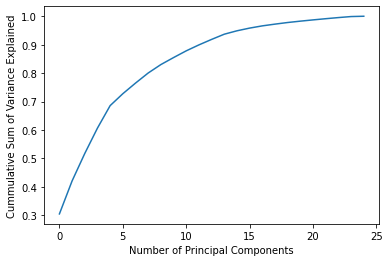

In [5]:
#Seeing if PCA helps the base model perform better before we tune our hyperparameters
pca = PCA(n_components=None)
"""scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)
pca.fit(x_train_scaled)"""
pca.fit(x_train)

print("Eigenvalues:")
print(pca.explained_variance_,"\n")

print("% Variance described: ")
print(pca.explained_variance_ratio_,"\n")

#Plotting these as a cummulative function to find the optimal n_components
pyplot.plot(np.cumsum(pca.explained_variance_ratio_))
pyplot.ylabel("Cummulative Sum of Variance Explained")
pyplot.xlabel("Number of Principal Components")

"""
From this plot, we can see that 15-17 principal components explain 95% of the variance of the data (each component orthogonal)
"""

In [6]:
#Setting n_components to be 15
pca = PCA(n_components=15)
x_train_transformed = pd.DataFrame(pca.fit_transform(x_train))
print(x_train_transformed)




           0         1         2         3         4         5         6   \
0    0.235102 -0.483535 -0.448497 -0.136874  0.337335 -0.043185  0.408097   
1   -0.657815  0.738105 -0.319322  0.081140  0.288492  0.140724  0.063187   
2   -0.786874  0.741927  0.274121 -0.208744 -0.332042 -0.176199 -0.047361   
3   -0.872231  0.898117  0.252846 -0.314479 -0.212829  0.102759 -0.088731   
4    1.041309  0.653485 -0.576863 -0.210810 -0.073880  0.095348  0.147340   
..        ...       ...       ...       ...       ...       ...       ...   
168  0.228486  0.805554  0.445586  1.079043  0.383117 -0.366556 -0.483162   
169  0.460933 -0.578435 -0.187362  0.472478 -0.689126 -0.070464 -0.214369   
170  0.500374  0.546333 -0.519176  0.597548 -0.869685  0.065309 -0.136654   
171  1.072223 -0.159328 -0.273825 -0.585501  0.172776  0.293088 -0.160340   
172  1.249704 -0.331826  0.668839  0.285577  0.584827 -0.143351 -0.013188   

           7         8         9         10        11        12        13  

Confusion Matrix:
 [[21  6]
 [ 7  9]] 

              precision    recall  f1-score   support

           0       0.75      0.78      0.76        27
           1       0.60      0.56      0.58        16

    accuracy                           0.70        43
   macro avg       0.68      0.67      0.67        43
weighted avg       0.69      0.70      0.70        43



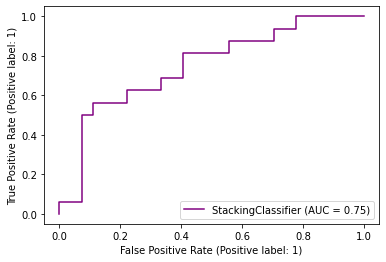

In [7]:
#Now test the model on the validation set to see if this improves it

# Level 0 Learners
base_learners = {
    "kNN": KNeighborsClassifier(),
    "logistic": LogisticRegression(),
    "forest": RandomForestClassifier(random_state = 21)
}


#Creating the level0 learners
lvl0 = []
for i in base_learners.keys():
    lvl0.append((i,base_learners[i]))

#Creating meta learner (level1 learner), logistic regression common for classification
lvl1 = LogisticRegression()

#Creating the stack model
model = StackingClassifier(estimators = lvl0, final_estimator = lvl1, cv=5)

model.fit(x_train_transformed, y_train.squeeze())

x_valid_transformed = pd.DataFrame(pca.fit_transform(x_valid))
y_pred = model.predict(x_valid_transformed)

evaluation(x_valid_transformed, y_valid, y_pred, model)

In [ ]:
#So no PCA needed since this doesnt improve our model much

C:\Users\alecb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.79210084 0.80369748 0.77512605        nan        nan
        nan 0.79243697 0.79815126        nan        nan        nan
 0.78067227 0.78084034        nan        nan        nan        nan
 0.79798319        nan 0.79815126        nan        nan        nan
        nan        nan        nan 0.79210084 0.80352941 0.78621849
        nan 0.78067227        nan        nan 0.80369748 0.79798319
 0.79798319 0.78638655        nan 0.79798319 0.79243697        nan
        nan 0.80352941        nan 0.7805042         nan        nan
 0.79798319        nan        nan        nan 0.7692437  0.78621849
 0.80403361        nan 0.79781513 0.79798319        nan        nan
        nan        nan        nan        nan 0.79210084 0.78638655
 0.79815126        nan        nan 0.77512605 0.79226891 0.79798319
        nan        nan        nan 0.78638655        n

{'logistic__solver': 'saga', 'logistic__penalty': 'none', 'logistic__C': 0.01, 'kNN__weights': 'distance', 'kNN__p': 2, 'kNN__n_neighbors': 25, 'kNN__metric': 'euclidean', 'kNN__leaf_size': 20, 'kNN__algorithm': 'ball_tree', 'forest__n_estimators': 250, 'forest__max_features': 'log2', 'forest__criterion': 'gini', 'forest__bootstrap': True}

Method 1: Best Score:  0.8040336134453782
Confusion Matrix:
 [[26  1]
 [ 7  9]] 

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        27
           1       0.90      0.56      0.69        16

    accuracy                           0.81        43
   macro avg       0.84      0.76      0.78        43
weighted avg       0.83      0.81      0.80        43



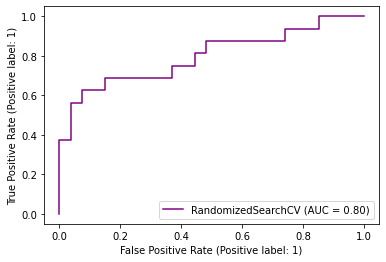

In [8]:
#Begin hyperparameter tuning using validation set
#Using a RandomSearch, on the ensemble:
base_learners = {
    "kNN": KNeighborsClassifier(),
    "logistic": LogisticRegression(),
    "forest": RandomForestClassifier(random_state = 21)
}

estimators = []
for i in base_learners.keys():
    estimators.append((i,base_learners[i]))

model = StackingClassifier(estimators = estimators, final_estimator =  LogisticRegression(), cv=5)

#Ensemble search space, too complex 
#Quick Search with random
parameters = {
    "kNN__n_neighbors": range(1,30),
    "kNN__weights": ["uniform", "distance"],
    "kNN__algorithm":["auto","ball_tree","kd_tree","brute"],
    "kNN__leaf_size":[5,10,20,30,40,50],
    "kNN__metric": ["euclidean", "manhattan","minkowski"],
    "kNN__p":[1,2],
    
    "logistic__penalty":["l1", "l2", "elasticnet", "none"],
    "logistic__C":[100, 10, 1.0, 0.1, 0.01],
    "logistic__solver":["newton-cg","lbfgs", "liblinear",
                        "sag", "saga"],
    
    "forest__n_estimators":[10,50,100,250,500,1000],
    "forest__criterion": ["gini", "entropy", "log_loss"],
    "forest__max_features":["sqrt", "log2"],
    "forest__bootstrap": [True, False]
}


#Note: this may take 5 minutes
#Note that the CV stands for crossvalidation since an internal cross validation is used to calculate score from hyperparams
tuned_model = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 100, n_jobs=-1,
                                 scoring="accuracy", random_state=21)
tuned_model.fit(x_train, y_train.squeeze())
randomParams = tuned_model.best_params_
print(randomParams)
print("\nMethod 1: Best Score: ", tuned_model.best_score_)

y_pred = tuned_model.predict(x_valid)

evaluation(x_valid, y_valid, y_pred, tuned_model)

#Note: all of the warnings come from incompatible matchups of logistic regression shrinkage terms (l1 or l2) and the differe
#algorithms as can be found in the scikitlearn API

In [9]:
#Tune each base learner separately (isolated tuning) via Grid Search
#kNN Tuning
kNN_params = {
    "n_neighbors": [5,10,15,20,25],
    "weights": ["uniform", "distance"],
    "algorithm":["auto","ball_tree","kd_tree","brute"],
    "leaf_size":[5,10,20,30,40,50],
    "metric": ["euclidean", "manhattan","minkowski"],
    "p":[1,2]
}

kNN = KNeighborsClassifier()
tuned_kNN = GridSearchCV(estimator = kNN, param_grid = kNN_params, n_jobs=-1, scoring="accuracy")
tuned_kNN.fit(x_train, y_train.squeeze())
kNNParams = tuned_kNN.best_params_
print(kNNParams)

"""y_pred = tuned_kNN.predict(x_valid)

evaluation(x_valid,y_valid, y_pred, tuned_kNN)"""

{'algorithm': 'auto', 'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


'y_pred = tuned_kNN.predict(x_valid)\n\nevaluation(x_valid,y_valid, y_pred, tuned_kNN)'

In [10]:
#Logistic Regression Tuning
logistic_params = {
    "penalty":["l1", "l2", "elasticnet", "none"],
    "C":[1000,100, 10, 1.0, 0.1, 0.01],
    "solver":["newton-cg","lbfgs", "liblinear", "sag", "saga"]
    
}

logistic = LogisticRegression()
tuned_logistic = GridSearchCV(estimator = logistic, param_grid = logistic_params, n_jobs=-1, scoring="accuracy")
tuned_logistic.fit(x_train, y_train.squeeze())
logisticParams = tuned_logistic.best_params_
print(logisticParams)

"""y_pred = tuned_logistic.predict(x_valid)

evaluation(x_valid,y_valid, y_pred, tuned_logistic)"""

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\alecb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.77512605        nan 0.79260504 0.7692437
 0.7692437  0.77512605 0.79260504 0.79260504        nan        nan
        nan        nan        nan 0.76941176 0.76941176        nan
 0.78689076 0.79260504        nan        nan 0.77512605        nan
 0.79260504 0.78689076 0.78689076 0.78689076 0.78689076 0.79260504
        nan        nan        nan        nan        nan 0.76941176
 0.76941176        nan 0.78689076 0.79260504        nan        nan
 0.79848739        nan 0.78672269 0.7810084  0.7810084  0.78672269
 0.77512605 0.77512605        nan        nan        nan        nan
        nan 0.76941176 0.76941176        nan 0.78689076 0.79260504
        nan        nan 0.81563025        nan 0.82151261 0.79798319
 0.79798319 0.80991597 0.79798319 0.79798319        nan        nan
        nan        nan        nan 0.76941176 0.7694117

'y_pred = tuned_logistic.predict(x_valid)\n\nevaluation(x_valid,y_valid, y_pred, tuned_logistic)'

In [11]:
#Random Forest Tuning
forest_params = {
    "n_estimators":[10,100,1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features":["sqrt", "log2"],
    "bootstrap": [True, False],
    "random_state":[21]
}

forest = RandomForestClassifier()
tuned_forest = GridSearchCV(estimator = forest, param_grid = forest_params, n_jobs=-1, scoring="accuracy")
tuned_forest.fit(x_train, y_train.squeeze())
forestParams = tuned_forest.best_params_
print(forestParams)

"""y_pred = tuned_forest.predict(x_valid)

evaluation(x_valid,y_valid, y_pred, tuned_forest)"""

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10, 'random_state': 21}


C:\Users\alecb\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.82689076 0.80941176 0.79798319 0.77462185 0.80386555 0.79226891
 0.78588235 0.79798319 0.79210084 0.78655462 0.78067227 0.79210084
        nan        nan        nan        nan        nan        nan
 0.79798319 0.79243697 0.80403361 0.77546218 0.78638655 0.78655462
 0.78621849 0.79226891 0.79226891 0.77495798 0.78067227 0.78638655
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


'y_pred = tuned_forest.predict(x_valid)\n\nevaluation(x_valid,y_valid, y_pred, tuned_forest)'

Confusion Matrix:
 [[25  2]
 [ 7  9]] 

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        27
           1       0.82      0.56      0.67        16

    accuracy                           0.79        43
   macro avg       0.80      0.74      0.76        43
weighted avg       0.79      0.79      0.78        43



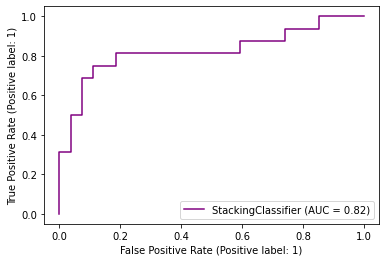

In [12]:
#Compare Isolated tuning with results of Randomised Search 
# Level 0 Learners
base_learners = {
    "kNN": KNeighborsClassifier(algorithm="auto", leaf_size=5, metric="manhattan",
                                n_neighbors=5, p=1, weights="uniform"),
    "logistic": LogisticRegression(C=0.1, penalty="l2", solver="newton-cg"),
    "forest": RandomForestClassifier(bootstrap=True, criterion="gini", max_features="sqrt",
                                     n_estimators=10, random_state = 21)
}


#Creating the level0 learners
lvl0 = []
for i in base_learners.keys():
    lvl0.append((i,base_learners[i]))

#Creating meta learner (level1 learner), logistic regression common for classification
lvl1 = LogisticRegression()

#Creating the stack model
model = StackingClassifier(estimators = lvl0, final_estimator = lvl1, cv=5)

#Fitting our training data to the stack and seeing the score on the validation set
fitted = model.fit(x_train, y_train.squeeze())
y_pred = model.predict(x_valid)

evaluation(x_valid,y_valid, y_pred, model)

{'forest__criterion': 'gini', 'forest__n_estimators': 100, 'forest__random_state': 21, 'kNN__metric': 'euclidean', 'kNN__n_neighbors': 5, 'logistic__penalty': 'l2', 'logistic__solver': 'newton-cg'}

Method 3: Best Score:  0.8268907563025211
Confusion Matrix:
 [[25  2]
 [ 8  8]] 

              precision    recall  f1-score   support

           0       0.76      0.93      0.83        27
           1       0.80      0.50      0.62        16

    accuracy                           0.77        43
   macro avg       0.78      0.71      0.72        43
weighted avg       0.77      0.77      0.75        43



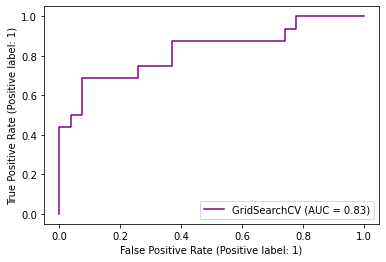

In [13]:
#Final method, restricted grid search on most important hyperparameters (manual tuning)
# Level 0 Learners
base_learners = {
    "kNN": KNeighborsClassifier(),
    "logistic": LogisticRegression(),
    "forest": RandomForestClassifier()
}


#Creating meta learner (level1 learner), logistic regression common for classification
lvl1 = LogisticRegression()


estimators = []
for i in base_learners.keys():
    estimators.append((i,base_learners[i]))

model = StackingClassifier(estimators = estimators, final_estimator =  lvl1, cv=5)

"""
This search space is too complex and can take up to years to complete, so we pick out the most relevant hyperparameters
to focus on optimising first


parameters = {
    "kNN__n_neighbors": range(1,30),
    "kNN__weights": ["uniform", "distance"],
    "kNN__algorithm":["auto","ball_tree","kd_tree","brute"],
    "kNN__leaf_size":[5,10,20,30,40,50],
    "kNN__metric": ["euclidean", "manhattan","minkowski"],
    "kNN__p":[1,2],
    
    "logistic__penalty":["l1", "l2", "elasticnet", "none"],
    "logistic__C":[100, 10, 1.0, 0.1, 0.01],
    "logistic__solver":["newton-cg","lbfgs", "liblinear", "sag", "saga"],
    
    "forest__n_estimators":[10,50,100,250,500,1000],
    "forest__criterion": ["gini", "entropy", "log_loss"],
    "forest__max_features":["sqrt", "log2"],
    "forest__bootstrap": [True, False]
}
"""

"""parameters = {
    "kNN__n_neighbors":[25],
    "kNN__metric": ["euclidean"],
    
    "logistic__penalty":["none"],
    "logistic__solver":["sag"],
    
    "forest__n_estimators":[10],
    "forest__criterion": ["gini"],
    "forest__random_state": [21]
}"""

#A more manageable search space for Grid Search
#(Running this takes an hour)
"""parameters = {
    "kNN__n_neighbors":[5,15,25],
    "kNN__metric": ["euclidean", "manhattan","minkowski"],
    
    "logistic__penalty":["l2","none"],
    "logistic__solver":["newton-cg","lbfgs", "liblinear", "sag", "saga"],
    
    "forest__n_estimators":[10,100,1000],
    "forest__criterion": ["gini","entropy","log_loss"],
    "forest__random_state": [21]
}"""

parameters = {
    "kNN__n_neighbors":[5],
    "kNN__metric": ["euclidean"],
    
    "logistic__penalty":["l2"],
    "logistic__solver":["newton-cg"],
    
    "forest__n_estimators":[100],
    "forest__criterion": ["gini"],
    "forest__random_state": [21]
}

"""{'forest__criterion': 'gini', 'forest__n_estimators': 100, 
 'forest__random_state': 21, 'kNN__metric': 'euclidean',
 'kNN__n_neighbors': 5, 'logistic__penalty': 'l2', 
 'logistic__solver': 'newton-cg'}"""


tuned_model = GridSearchCV(estimator = model, param_grid = parameters, n_jobs=-1, scoring="accuracy")
tuned_model.fit(x_train, y_train.squeeze())
gridParams = tuned_model.best_params_
print(gridParams)
print("\nMethod 3: Best Score: ", tuned_model.best_score_)

y_pred = tuned_model.predict(x_valid)

evaluation(x_valid,y_valid, y_pred, tuned_model)

In [14]:
#Train the best model on the training and validation data
#Currently, the best performing model is the one I manually tuned 26,1,6,10 the one above

base_learners = {
    "kNN": KNeighborsClassifier(metric = "euclidean",n_neighbors=5),
    "logistic": LogisticRegression(penalty="l2",solver="newton-cg"),
    "forest": RandomForestClassifier(criterion="gini", n_estimators=100, random_state=21)
}

#{'logistic__solver': 'saga', 'logistic__penalty': 'none', 'logistic__C': 0.01, 'kNN__weights': 'distance', 'kNN__p': 2, 
#'kNN__n_neighbors': 25, 'kNN__metric': 'euclidean',
#'kNN__leaf_size': 20, 'kNN__algorithm': 'ball_tree', 'forest__n_estimators': 250, 
#'forest__max_features': 'log2', 'forest__criterion': 'gini', 'forest__bootstrap': True}


#{'forest__criterion': 'gini', 'forest__n_estimators': 10, 'forest__random_state': 21, 'kNN__metric': 'euclidean', 'kNN__n_neighbors': 25, 'logistic__penalty': 'none', 'logistic__solver': 'sag'}

lvl1 = LogisticRegression()
lvl0 = []
for i in base_learners.keys():
    lvl0.append((i,base_learners[i]))

final_model = StackingClassifier(estimators = lvl0, final_estimator =  lvl1, cv=5)






Confusion Matrix:
 [[42  5]
 [ 3 23]] 

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        47
           1       0.82      0.88      0.85        26

    accuracy                           0.89        73
   macro avg       0.88      0.89      0.88        73
weighted avg       0.89      0.89      0.89        73



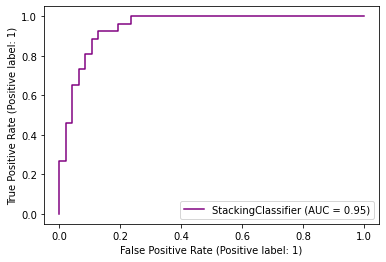

In [15]:
#Merge training and validation data
x_trainingV = pd.concat([x_train, x_valid])
y_trainingV = pd.concat([y_train, y_valid])

#fit the final model on this data
final_model.fit(x_trainingV, y_trainingV.squeeze())

#Evaluate the results on the Test Set
y_pred = final_model.predict(x_test)
evaluation(x_test,y_test,y_pred,final_model)

In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
##Multiple ROC Curves:
pyplot.figure(0).clf()

#logistic regression
model = LogisticRegression(C = 0.05963623316594643, penalty="l2", solver="lbfgs")
model.fit(x_trainingV, y_trainingV)

print(model.coef_, model.intercept_)
y_pred = model.predict(x_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
evaluation(x_test,y_test,y_pred,model)

y_pred = model.predict_proba(x_test)[:, 1]
fpr, tpr, na = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 2)

pyplot.plot(fpr,tpr,label="Logistic Regression AUC: "+str(auc))

#kNN
model = KNeighborsClassifier(leaf_size=1, metric="manhattan", n_neighbors=15, weights="uniform")
model.fit(x_trainingV, y_trainingV)
y_pred = model.predict_proba(x_test)[:, 1]
fpr, tpr, na = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 2)
pyplot.plot(fpr,tpr,label="KNN AUC: "+str(auc))

#ensembe stack
final_model.fit(x_trainingV, y_trainingV)
y_pred = final_model.predict_proba(x_test)[:, 1]
fpr, tpr, na = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 2)
pyplot.plot(fpr,tpr,label="Stack AUC: "+str(auc))

pyplot.ylabel("True Positive Rate ->")
pyplot.xlabel("False Positive Rate ->")

#add legend
pyplot.legend()
pyplot.show()


In [ ]:
base_learners = {
    "kNN": KNeighborsClassifier(metric = "euclidean",n_neighbors=5),
    "logistic": LogisticRegression(penalty="l2",solver="newton-cg"),
    "forest": RandomForestClassifier(criterion="gini", n_estimators=100, random_state=21)
}

#{'logistic__solver': 'saga', 'logistic__penalty': 'none', 'logistic__C': 0.01, 'kNN__weights': 'distance', 'kNN__p': 2, 
#'kNN__n_neighbors': 25, 'kNN__metric': 'euclidean',
#'kNN__leaf_size': 20, 'kNN__algorithm': 'ball_tree', 'forest__n_estimators': 250, 
#'forest__max_features': 'log2', 'forest__criterion': 'gini', 'forest__bootstrap': True}


#{'forest__criterion': 'gini', 'forest__n_estimators': 10, 'forest__random_state': 21, 'kNN__metric': 'euclidean', 'kNN__n_neighbors': 25, 'logistic__penalty': 'none', 'logistic__solver': 'sag'}

lvl1 = LogisticRegression()
lvl0 = []
for i in base_learners.keys():
    lvl0.append((i,base_learners[i]))

final_model = StackingClassifier(estimators = lvl0, final_estimator =  lvl1, cv=5)

In [ ]:
##Multiple Precision/Recall Curves:
pyplot.figure(1).clf()





#logistic regression
model = LogisticRegression(C = 0.05963623316594643, penalty="l2", solver="lbfgs")
model.fit(x_trainingV, y_trainingV)
y_pred = model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

pyplot.plot(recall,precision,label="Logistic Regression")

#kNN
model = KNeighborsClassifier(leaf_size=1, metric="manhattan", n_neighbors=15, weights="uniform")
model.fit(x_trainingV, y_trainingV)
y_pred = model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pyplot.plot(recall,precision,label="KNN")

#ensembe stack
final_model.fit(x_trainingV, y_trainingV)
y_pred = final_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pyplot.plot(recall,precision,label="Stack")

pyplot.ylabel("Precision")
pyplot.xlabel("Recall")



#add legend
pyplot.legend()
pyplot.show()